# Days in shelter Classification

## Import Data

In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , FunctionTransformer,OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector,ColumnTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from From_Shelter_to_Love.data_provisoria_v2 import get_data

In [22]:
#Getting the data

df = get_data()
df.dropna(inplace=True)
df.head(2)

,Animal ID,Intake Type,Intake Condition,Animal Type,Breed,Outcome Type,days_in_shelter,age_upon_intake_months,age_upon_intake_years,age_upon_outcome_months,age_upon_outcome_years,neutered_or_spayed_outcome,male_or_female_outcome,neutered_or_spayed_intake,male_or_female_intake,color
0,A006100,Public Assist,Normal,Dog,Mixed,Return to Owner,2.0,72.0,6.0,72.0,6.0,1,1.0,1,1.0,Bicolor
1,A047759,Owner Surrender,Normal,Dog,Pure,Transfer,5.0,120.0,10.0,120.0,10.0,1,1.0,1,1.0,Tricolor


In [23]:
df.drop(columns = ['Animal ID','age_upon_outcome_years','age_upon_intake_years',\
                   'age_upon_outcome_months','male_or_female_outcome',\
                   'neutered_or_spayed_outcome'], inplace = True)
df.head(2)

,Intake Type,Intake Condition,Animal Type,Breed,Outcome Type,days_in_shelter,age_upon_intake_months,neutered_or_spayed_intake,male_or_female_intake,color
0,Public Assist,Normal,Dog,Mixed,Return to Owner,2.0,72.0,1,1.0,Bicolor
1,Owner Surrender,Normal,Dog,Pure,Transfer,5.0,120.0,1,1.0,Tricolor


In [24]:
df_dogs = df[df['Animal Type'] == 'Dog'].copy()
df_dogs.drop(columns = 'Animal Type', inplace = True)

## 1st Approach

In [27]:
def classes(df,column):
    target = []
    for days in df[column]:
        if days < 2:
            target.append(0)
        elif 2 <= days < 8:
            target.append(1)
        else:
            target.append(2)
    df['target'] = target
    return df

classes(df_dogs,"days_in_shelter").head(2)

,Intake Type,Intake Condition,Breed,Outcome Type,days_in_shelter,age_upon_intake_months,neutered_or_spayed_intake,male_or_female_intake,color,target
0,Public Assist,Normal,Mixed,Return to Owner,2.0,72.0,1,1.0,Bicolor,1
1,Owner Surrender,Normal,Pure,Transfer,5.0,120.0,1,1.0,Tricolor,1


In [496]:
#Checking the balance of target
df_dogs.target.value_counts()

0    35242
1    23215
Name: target, dtype: int64

### Creating variables for features and target

In [28]:
X = df_dogs.drop(columns = ['days_in_shelter', 'target', 'Outcome Type']).copy()
y = df_dogs['target'].copy()

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 10)

In [286]:
X_train.shape

(40919, 7)

### Pre-processing Pipeline

In [316]:
# Impute then Scale for numerical variables
num_transformer = MinMaxScaler()

# Encode categorical varibles 
cat_transformer = OneHotEncoder(handle_unknown='ignore',sparse=False)

# Apply transformations to desired features
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['int64',"float64"])),
    ('cat_transformer', cat_transformer, make_column_selector(dtype_include=["object"]))])

In [317]:
from sklearn import set_config; set_config(display='diagram')
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_transformer', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7faefebe88b0>),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7faefa8e8fd0>)])

In [318]:
X_train_new = preprocessor.transform(X_train)
X_test_new = preprocessor.transform(X_test)

In [319]:
from imblearn.over_sampling import SMOTE
#Create an oversampled training data
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(X_train_new, y_train)

### Grid Search

In [320]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer

# Model
forest = RandomForestClassifier()

#GridSearch

grid_params = {'n_estimators': [25,50,100],
               'max_depth': [5,10,20],
              }

grid_search = GridSearchCV(forest, grid_params,
                           scoring = 'f1_macro',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          )

# Fit data to Grid Search
grid_search.fit(X_oversample, y_oversample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100]},
             scoring='f1_macro')

In [321]:
# Best score
grid_search.best_score_

0.7409502778466456

In [322]:
# Best Params
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 50}

In [323]:
# Best estimator
grid_search.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=50)

### Model

In [325]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 10)

forest.fit(X_oversample, y_oversample)

preds = forest.predict(X_test_new)

In [326]:
from sklearn.metrics import f1_score

f1_score(y_test,preds,average = None)

array([0.41061331, 0.85574364])

### Confusion Matrix

In [300]:
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": preds}) #Store results in dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])

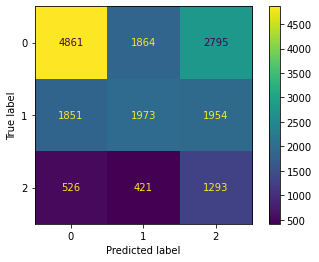

In [301]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(forest, X_test_new, y_test)  #Not normalized
plt.show()  

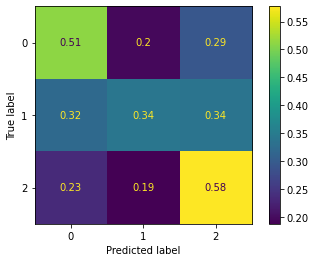

In [302]:
plot_confusion_matrix(forest, X_test_new, y_test, normalize = 'true')  #Rows
plt.show()  

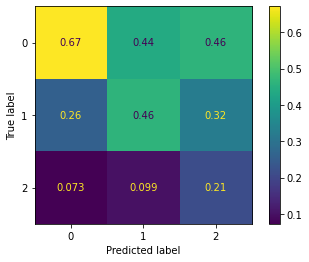

In [303]:
plot_confusion_matrix(forest, X_test_new, y_test, normalize = 'pred')  #Columns
plt.show()  

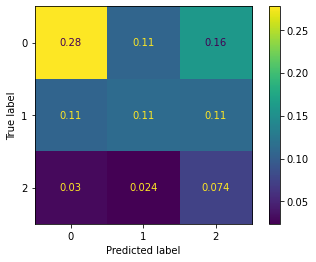

In [304]:
plot_confusion_matrix(forest, X_test_new, y_test, normalize = 'all')  #All
plt.show()  

## 2nd Approach

1 day or more than 1 day

In [124]:
def classes(df,column):
    target = []
    for days in df[column]:
        if days <= 31:
            target.append(0)
        else:
            target.append(1)
    df['target'] = target
    return df

classes(df_dogs,"days_in_shelter").head(2)

,Intake Type,Intake Condition,Breed,Outcome Type,days_in_shelter,age_upon_intake_months,neutered_or_spayed_intake,male_or_female_intake,color,target
0,Public Assist,Normal,Mixed,Return to Owner,2.0,72.0,1,1.0,Bicolor,0
1,Owner Surrender,Normal,Pure,Transfer,5.0,120.0,1,1.0,Tricolor,0


In [125]:
X = df_dogs.drop(columns = ['days_in_shelter', 'target', 'Outcome Type']).copy()
y = df_dogs['target'].copy()

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 10)

### Pre-processing Pipeline

In [127]:
# Impute then Scale for numerical variables
num_transformer = MinMaxScaler()

# Encode categorical varibles 
cat_transformer = OneHotEncoder(handle_unknown='ignore',sparse=False)

# Apply transformations to desired features
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['int64',"float64"])),
    ('cat_transformer', cat_transformer, make_column_selector(dtype_include=["object"]))])

In [128]:
from sklearn import set_config; set_config(display='diagram')
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_transformer', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fba421f2100>),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fba421f24f0>)])

In [129]:
X_train_new = preprocessor.transform(X_train)
X_test_new = preprocessor.transform(X_test)

In [130]:
from imblearn.over_sampling import SMOTE
#Create an oversampled training data
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(X_train_new, y_train)

### Grid Search

In [131]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer

# Model
forest = RandomForestClassifier()

#GridSearch

grid_params = {'n_estimators': [25,50,100],
               'max_depth': [5,10,20],
              }

grid_search = GridSearchCV(forest, grid_params,
                           scoring = 'f1_macro',
                           cv = 5,
                          )

# Fit data to Grid Search
grid_search.fit(X_oversample, y_oversample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100]},
             scoring='f1_macro')

In [132]:
# Best score
grid_search.best_score_

0.704942608852006

In [133]:
# Best Params
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 50}

### Model

In [141]:
forest = RandomForestClassifier(n_estimators = 50, max_depth = 20)

forest.fit(X_oversample, y_oversample)

preds = forest.predict(X_test_new)

In [142]:
from sklearn.metrics import f1_score

f1_score(y_test,preds,average = None)

array([0.75362764, 0.28894305])

In [143]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,preds)

0.6340517732922796

### Confusion Matrix

In [144]:
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": preds}) #Store results in dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])

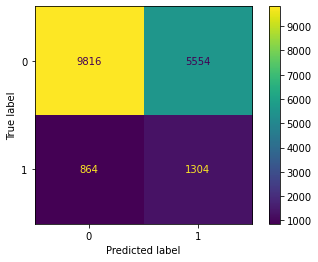

In [145]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(forest, X_test_new, y_test)  #Not normalized
plt.show()  

## 3rd Approach

Dropping all the dogs who found home in 1st week

In [6]:
def classes(df,column):
    target = []
    for days in df[column]:
        if days <= 7:
            target.append(0)
        else:
            target.append(1)
    df['target'] = target
    return df

classes(df_dogs,"days_in_shelter").head(2)

,Intake Type,Intake Condition,Breed,Outcome Type,days_in_shelter,age_upon_intake_months,neutered_or_spayed_intake,male_or_female_intake,color,target
0,Public Assist,Normal,Mixed,Return to Owner,2.0,72.0,1,1.0,Bicolor,0
1,Owner Surrender,Normal,Pure,Transfer,5.0,120.0,1,1.0,Tricolor,0
